In [1]:
import numpy as np
from scipy import stats as st
from scipy.optimize import minimize
from scipy.special import erf
import sympy as sp
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Signal Detection Theory (SDT)

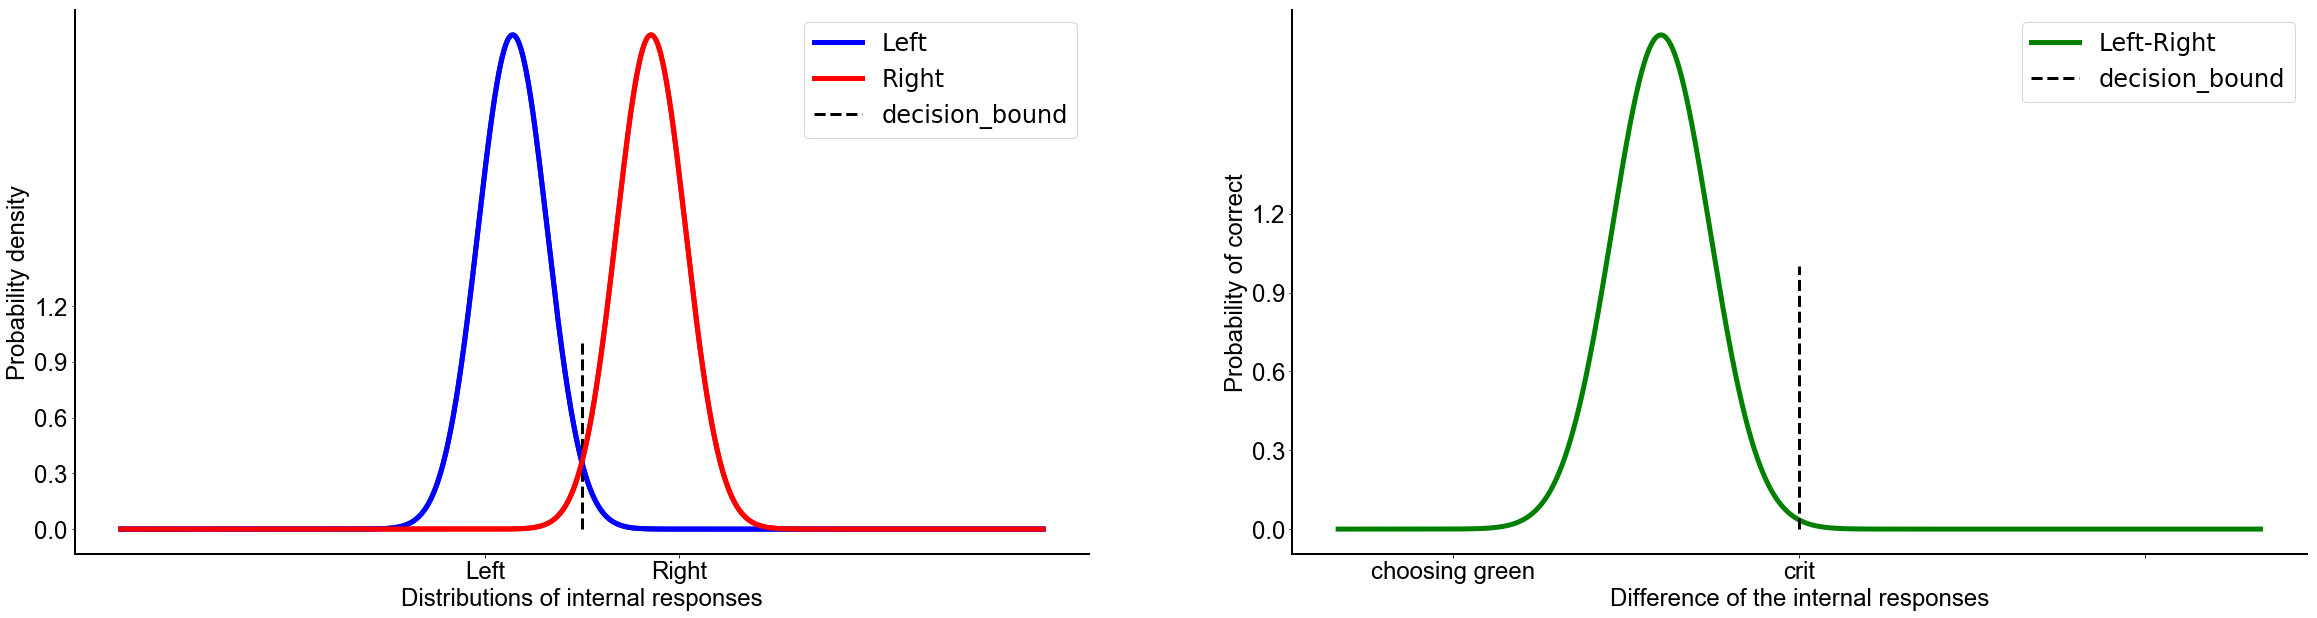

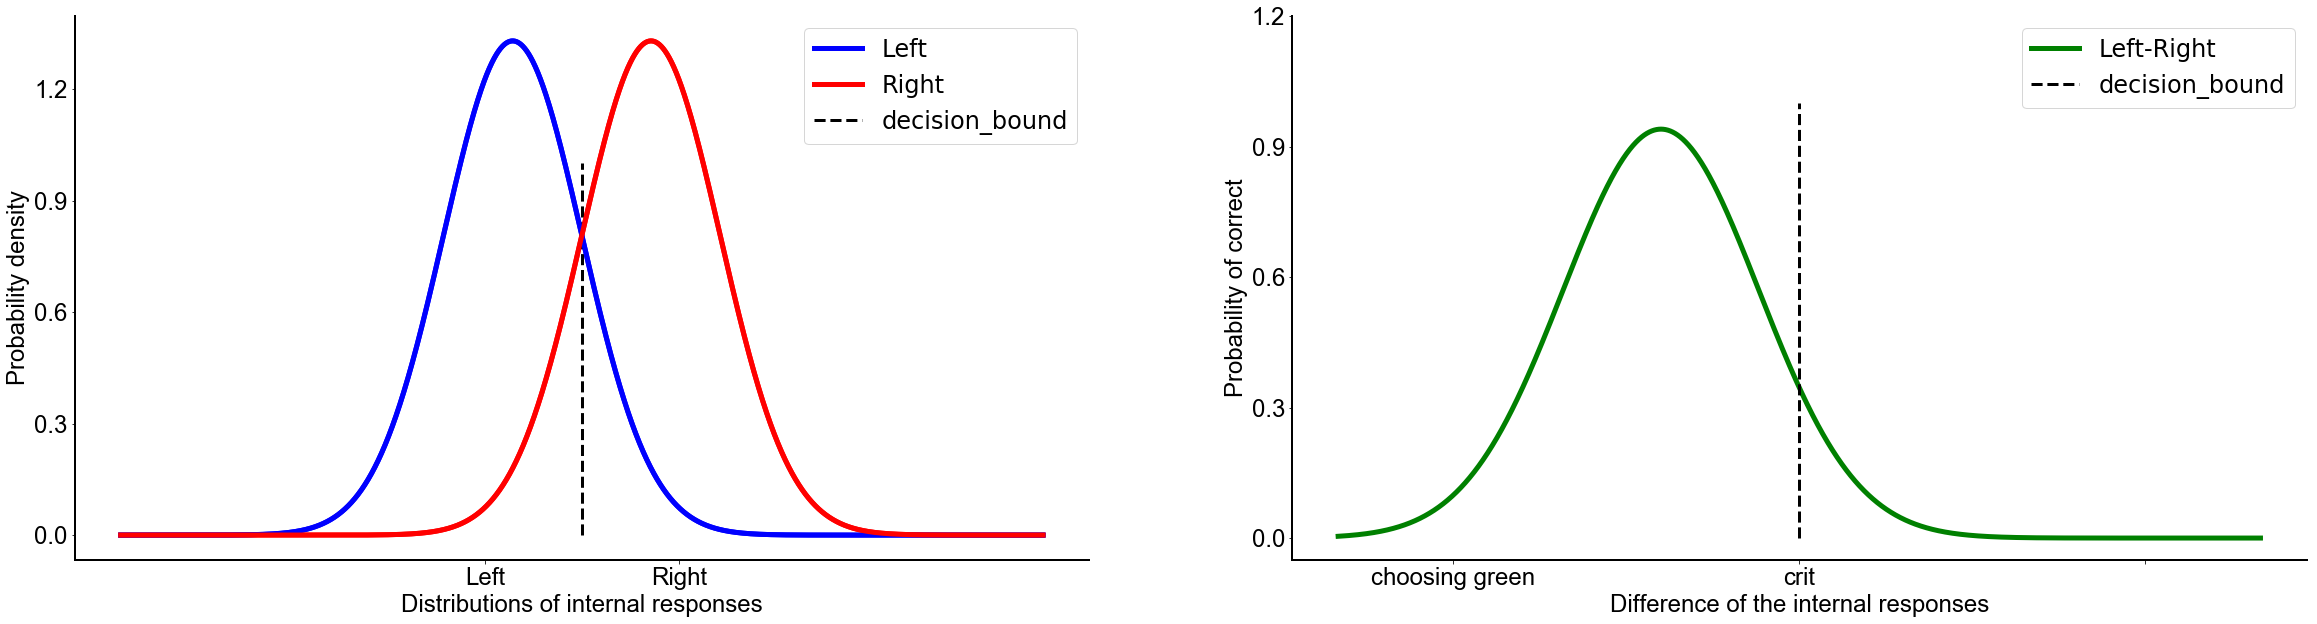

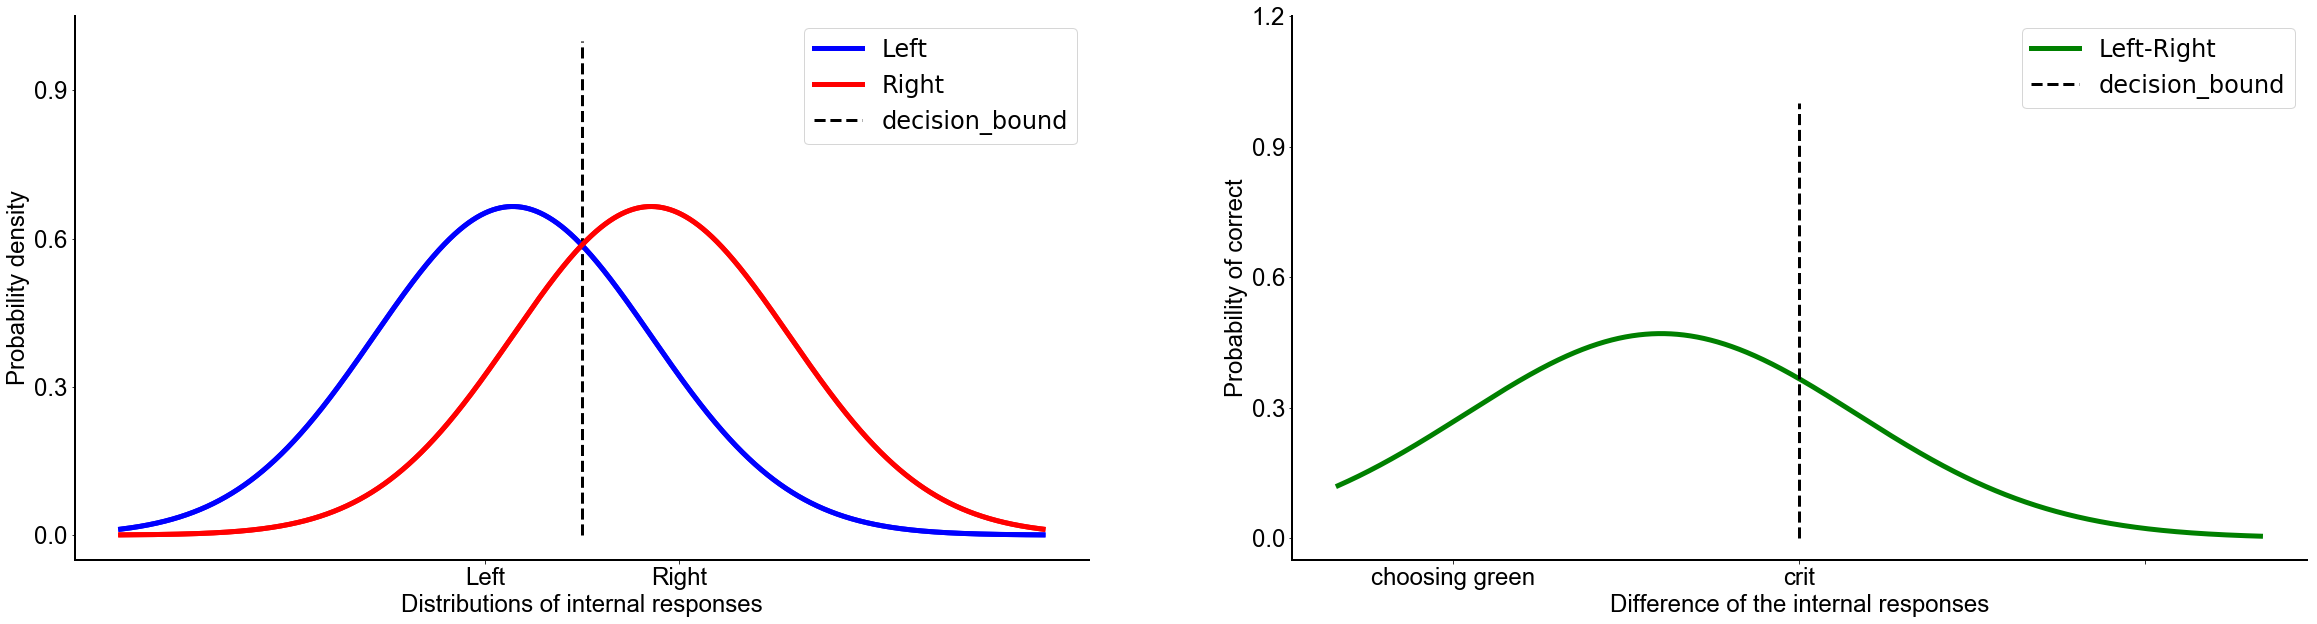

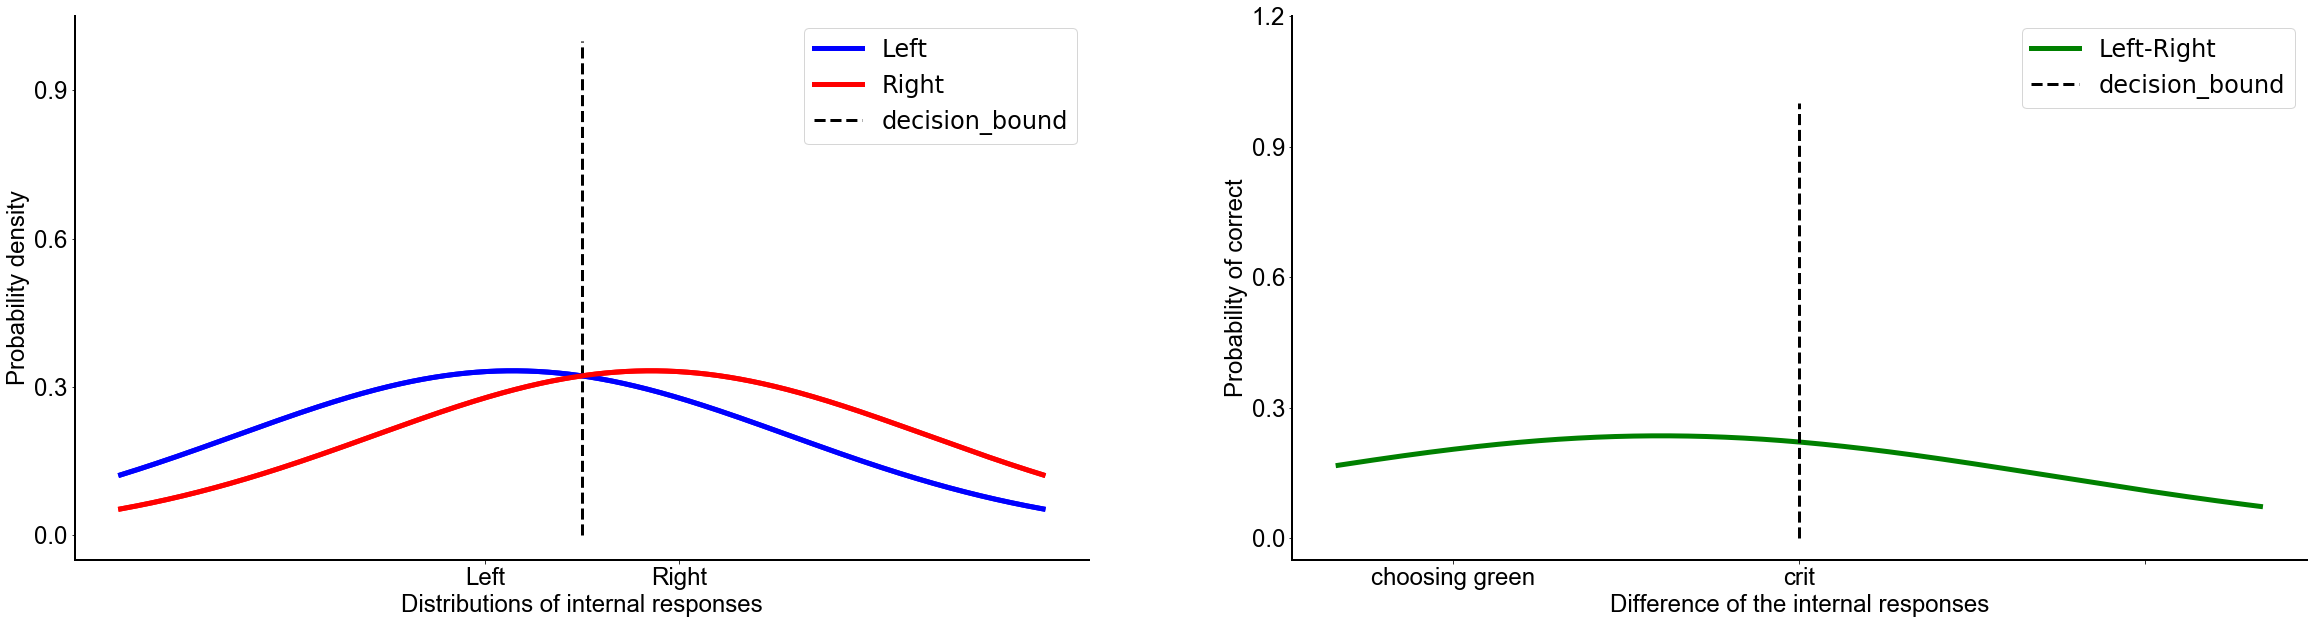

In [3]:
N = 5000
x = np.linspace(-2,2,N)
m = np.array([-0.3,0.3])
var = [0.15, 0.3, 0.6, 1.2]
pdfs = np.zeros((len(m),N))

axisFont = {'fontname':'Arial', 'size':'24'}
axisWidth = 2
col_space = np.linspace(0, 0.6, len(m))
col_space2 = np.linspace(0, 0.8, len(m))
lx = ['Distributions of internal responses','Difference of the internal responses']
ly = ['Probability density','Probability of correct']
t = [['Left','Right'],['Left-Right', 'choosing red', 'choosing green','crit']]
ck = [(0,0,1),(1,0,0),(0,1,0),(0,0.5,0)]
lw = 5
for sgm in var:
    fig, ax = plt.subplots(1,2, figsize=(40, 10))
    for s in range(2):

        for i,mi in enumerate(m):
            pdfs[i,:] = st.norm.pdf(x, loc=m[i], scale=sgm)
            ax[0].plot(x,pdfs[i,:], '-', linewidth = lw, color = ck[i], label=t[0][i])
        if s==1:
            ax[1].plot(x,st.norm.pdf(x, loc=m[0]-m[1], scale=np.sqrt(sgm**2+sgm**2)), color = 'g', linewidth = lw, label=t[1][0])


        ax[s].plot([0,0],[0,1], 'k--', linewidth = 3, label='decision_bound')    
        ax[0].xaxis.set_ticks(m*1.4)
        ax[0].xaxis.set_ticklabels(t[0])
        ax[1].xaxis.set_ticks([-1.5,0,1.5])
        ax[1].xaxis.set_ticklabels(t[1][2:])
        for label in (ax[s].get_xticklabels() + ax[s].get_yticklabels()):
            label.set_fontname(axisFont['fontname'])
            label.set_fontsize(axisFont['size'])

        ax[s].spines['right'].set_visible(False)
        ax[s].spines['top'].set_visible(False)
        ax[s].spines['left'].set_linewidth(axisWidth)
        ax[s].spines['bottom'].set_linewidth(axisWidth)
        ax[s].xaxis.set_ticks_position('bottom')
        ax[s].yaxis.set_ticks_position('left')
        ax[s].set_xlabel(lx[s], **axisFont)
        ax[s].set_ylabel(ly[s], **axisFont)
        ax[s].yaxis.set_ticks([0,0.3,0.6,0.9,1.20001])
        ax[s].legend(loc='best', fontsize=axisFont['size'])
    if sgm==0.3:
        plt.savefig('std0.pdf')
    plt.show()

# Generating Responses from SDT

In [4]:
Npoints = 8
crit = [-0.8,0,0.8]
Npoints = 8
x = np.linspace(-2,2,Npoints)
response = np.zeros((Npoints,len(var),len(crit)))

for t,thr in enumerate(crit):
    for v,sgm in enumerate(var):

        response[:,v,t] = 1-st.norm.cdf(0, loc=x-thr, scale=sgm)      

# Fitting the weibul model (approximation for the Gaussian CDF)

In [11]:
class weibull_model:
    
    """ Fitting a Weibull model """
    
    def __init__(self, fit_data):
        
        self.eps = 2.2204e-16
        self.x = fit_data[0]+self.eps
        self.y = fit_data[1]
        self.n = fit_data[2]

        
    def weibull_fit(self):
    #[bhat, logl,xi,yi]=weibull_fit(x,y)
    #Fits the weibull model to (x,y) data set and returns the estimates bhat
    #and the log-likeliihood (logl) and interpolated xi and yi from fit
    #
    #The weibull function is P(correct)=1-0.5 exp[-(x/alpha)^beta]
    #here bhat(1)=alpha amd bhat(2)=beta
        bnds = ((0., np.max(self.x)), (0., None), (0+self.eps, 0.5-self.eps), (0.5+self.eps, 1-self.eps))
        self.weibull_jac()
        res = minimize(self.weibull_dist,(1.0,1.0,0.1,0.9), args = (self.x, self.y, self.n),  bounds = bnds)

        self.opt_param = res.x
        self.nlogl = res.fun

        xi=np.linspace(min(self.x),max(self.x),100)
        yi=self.weibull_pred(xi, self.opt_param)      
        self.pred = np.vstack((xi,yi))


    def weibull_dist(self,b,x,y,n):
    #returns the log likelihood

    #this is the weibull function that we are fitting
    #goes between p =0.5 and p=1.0
    #paramerized with squares to ensure that the params are positive

        p = self.weibull_pred(x,b)                     
        p=np.clip(p,self.eps,1-self.eps)

        return -n*np.sum(y * np.log(p) + (1-y) * np.log(1-p))
    
    
    def weibull_jac(self):
        
        b0,b1,b2,b3,x,y = sp.symbols(('b0','b1','b2','b3','x','y'),real=True)

        p = b2 + (1-b2-(1-b3)) * (1- sp.exp( -(x/(b0**2))**(b1**2)))
        f = -(y * sp.log(p) + (1-y) * sp.log(1-p))
        f = sp.simplify(f)
        vars = (b0,b1,b2,b3)
        J = sp.zeros(1,len(vars))
        for j, s in enumerate(vars):
            J[j] = sp.simplify(sp.diff(f, s))
        
        global J0,J1,J2,J3
        
        J0 = sp.lambdify((b0,b1,b2,b3,x,y), J[0])
        J1 = sp.lambdify((b0,b1,b2,b3,x,y), J[1])
        J2 = sp.lambdify((b0,b1,b2,b3,x,y), J[2])
        J3 = sp.lambdify((b0,b1,b2,b3,x,y), J[3])
        
        
    def weibull_jac_calc(self,b,x,y,n):

        jac0 = np.nansum(n*J0(b[0],b[1],b[2],b[3],x,y))
        jac1 = np.nansum(n*J1(b[0],b[1],b[2],b[3],x,y))
        jac2 = np.nansum(n*J2(b[0],b[1],b[2],b[3],x,y))
        jac3 = np.nansum(n*J3(b[0],b[1],b[2],b[3],x,y))
        #print(b)
        #print(np.array([jac0,jac1,jac2,jac3]))
        return np.array([jac0,jac1,jac2,jac3])
    

    def weibull_pred(self, x ,b):

        return b[2] + (1-b[2]-(1-b[3])) * (1 - np.exp( -(x/(b[0]**2))**(b[1]**2)))

/home/lengyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/home/lengyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in power


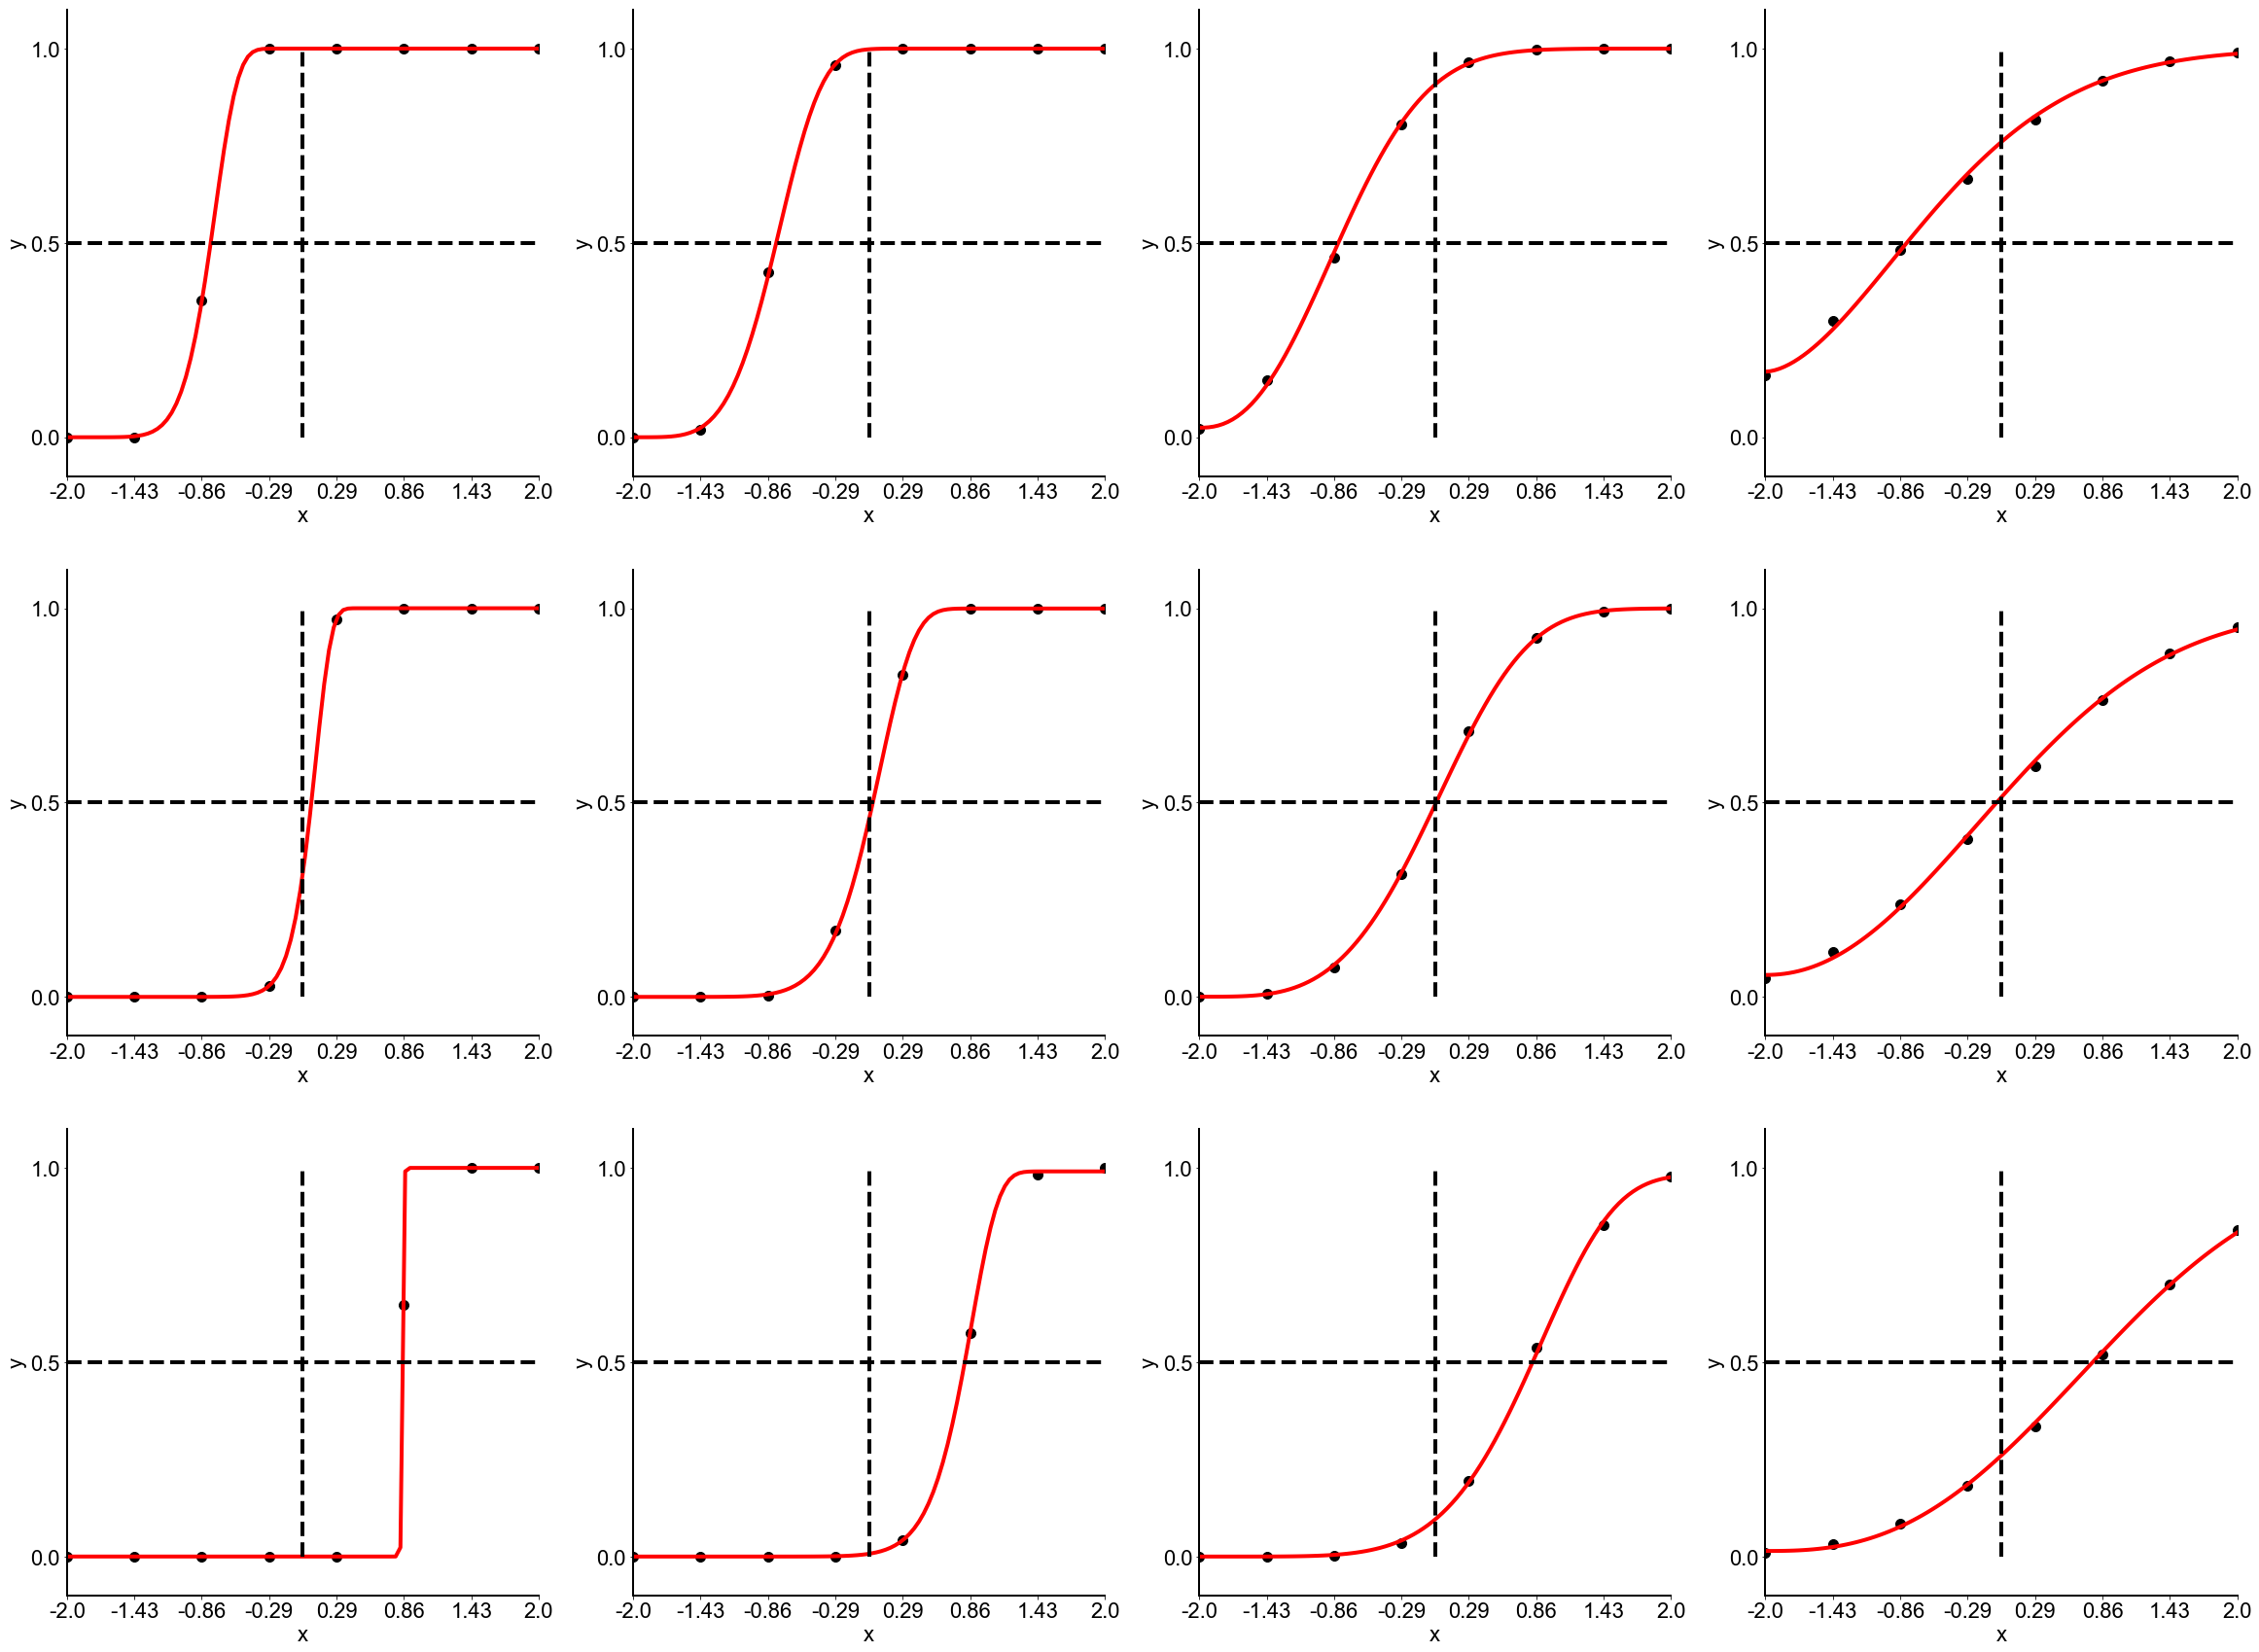

In [12]:
axisFont = {'fontname':'Arial', 'size':'22'}
axisWidth = 2
lw = 4
shift = np.max(x)
Ntrials=20

fig, ax = plt.subplots(response.shape[2],response.shape[1], figsize=(response.shape[1]*10, response.shape[2]*10))
ax = np.ravel(ax)

i=0
for t,thr in enumerate(crit):
    for v,sgm in enumerate(var):
    
        M = weibull_model((x+shift,response[:,v,t],N))
        M.weibull_fit()
        ax[i].plot(x+shift,response[:,v,t],'o', markersize=10, color = 'k')
        ax[i].plot(M.pred[0,:],M.pred[1,:], '-',linewidth = lw, color = 'r')
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            label.set_fontname(axisFont['fontname'])
            label.set_fontsize(axisFont['size'])
        ax[i].plot([np.min(x+shift), np.max(x+shift)],[0.5,0.5],'k--',linewidth = lw)
        ax[i].plot([shift, shift],[0,1],'k--',linewidth = lw)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_linewidth(axisWidth)
        ax[i].spines['bottom'].set_linewidth(axisWidth)
        ax[i].xaxis.set_ticks_position('bottom')
        ax[i].yaxis.set_ticks_position('left')
        ax[i].set_xlabel('x', **axisFont)
        ax[i].set_ylabel('y', **axisFont)
        ax[i].set_xlim([0,4])
        ax[i].set_ylim([-0.1,1.1])
        ax[i].xaxis.set_ticks(x+shift)
        ax[i].yaxis.set_ticks([0,0.5,1])
        ax[i].xaxis.set_ticklabels(np.round(x,2))
        i=i+1
    #plt.savefig('weibull_fit.pdf')
plt.show()

# Fitting the logistic model (approximation for the Gaussian CDF)

In [7]:
class logistic_model:
    
    """ Fitting a logistic model """
    
    def __init__(self, fit_data):
        
        self.eps = 2.2204e-16
        self.x = fit_data[0]
        self.y = fit_data[1]
        self.n = fit_data[2]

        
    def logistic_fit(self):
    #[bhat, logl,xi,yi]=weibull_fit(x,y)
    #Fits the weibull model to (x,y) data set and returns the estimates bhat
    #and the log-likeliihood (logl) and interpolated xi and yi from fit
    #
    #The weibull function is P(correct)=1-0.5 exp[-(x/alpha)^beta]
    #here bhat(1)=alpha amd bhat(2)=beta
        bnds = ((np.min(self.x), np.max(self.x)), (0+self.eps, None), (0, 0.5), (0.5, 1))
        self.logistic_jac()
        res = minimize(self.logistic_dist,(0,0.5,0.1,0.9), args = (self.x, self.y, self.n), jac = self.logistic_jac_calc, bounds = bnds)

        self.opt_param = res.x
        self.nlogl = res.fun

        xi=np.linspace(min(self.x),max(self.x),100)
        yi=self.logistic_pred(xi, self.opt_param)      
        self.pred = np.vstack((xi,yi))


    def logistic_dist(self,b,x,y,n):
    #returns the log likelihood

    #this is the weibull function that we are fitting
    #goes between p =0.5 and p=1.0
    #paramerized with squares to ensure that the params are positive

        p = self.logistic_pred(x,b)                     
        p=np.clip(p,self.eps,1-self.eps)
        return -n*np.sum(y * np.log(p) + (1-y) * np.log(1-p))
    
    
    def logistic_jac(self):
        
        b0,b1,b2,b3,x,y = sp.symbols(('b0','b1','b2','b3','x','y'),real=True)

        p = b2 + (1-b2-(1-b3)) * (1.0/(1.0+sp.exp(-b1*(x-b0))))
        f = -(y * sp.log(p) + (1-y) * sp.log(1-p))
        f = sp.simplify(f)
        vars = (b0,b1,b2,b3)
        J = sp.zeros(1,len(vars))
        for j, s in enumerate(vars):
            J[j] = sp.simplify(sp.diff(f, s))
        
        global J0,J1,J2,J3
        
        J0 = sp.lambdify((b0,b1,b2,b3,x,y), J[0])
        J1 = sp.lambdify((b0,b1,b2,b3,x,y), J[1])
        J2 = sp.lambdify((b0,b1,b2,b3,x,y), J[2])
        J3 = sp.lambdify((b0,b1,b2,b3,x,y), J[3])
        
        
    def logistic_jac_calc(self,b,x,y,n):

        jac0 = np.nansum(n*J0(b[0],b[1],b[2],b[3],x,y))
        jac1 = np.nansum(n*J1(b[0],b[1],b[2],b[3],x,y))
        jac2 = np.nansum(n*J2(b[0],b[1],b[2],b[3],x,y))
        jac3 = np.nansum(n*J3(b[0],b[1],b[2],b[3],x,y))
        #print(b)
        #print(np.array([jac0,jac1,jac2,jac3]))
        return np.array([jac0,jac1,jac2,jac3])
    

    def logistic_pred(self, x ,b):

        return b[2] + (1-b[2]-(1-b[3])) * (1.0/(1.0+np.exp(-b[1]*(x-b[0]))))

<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide
<string>:2: RuntimeWarning: invalid value encountered in true_divide


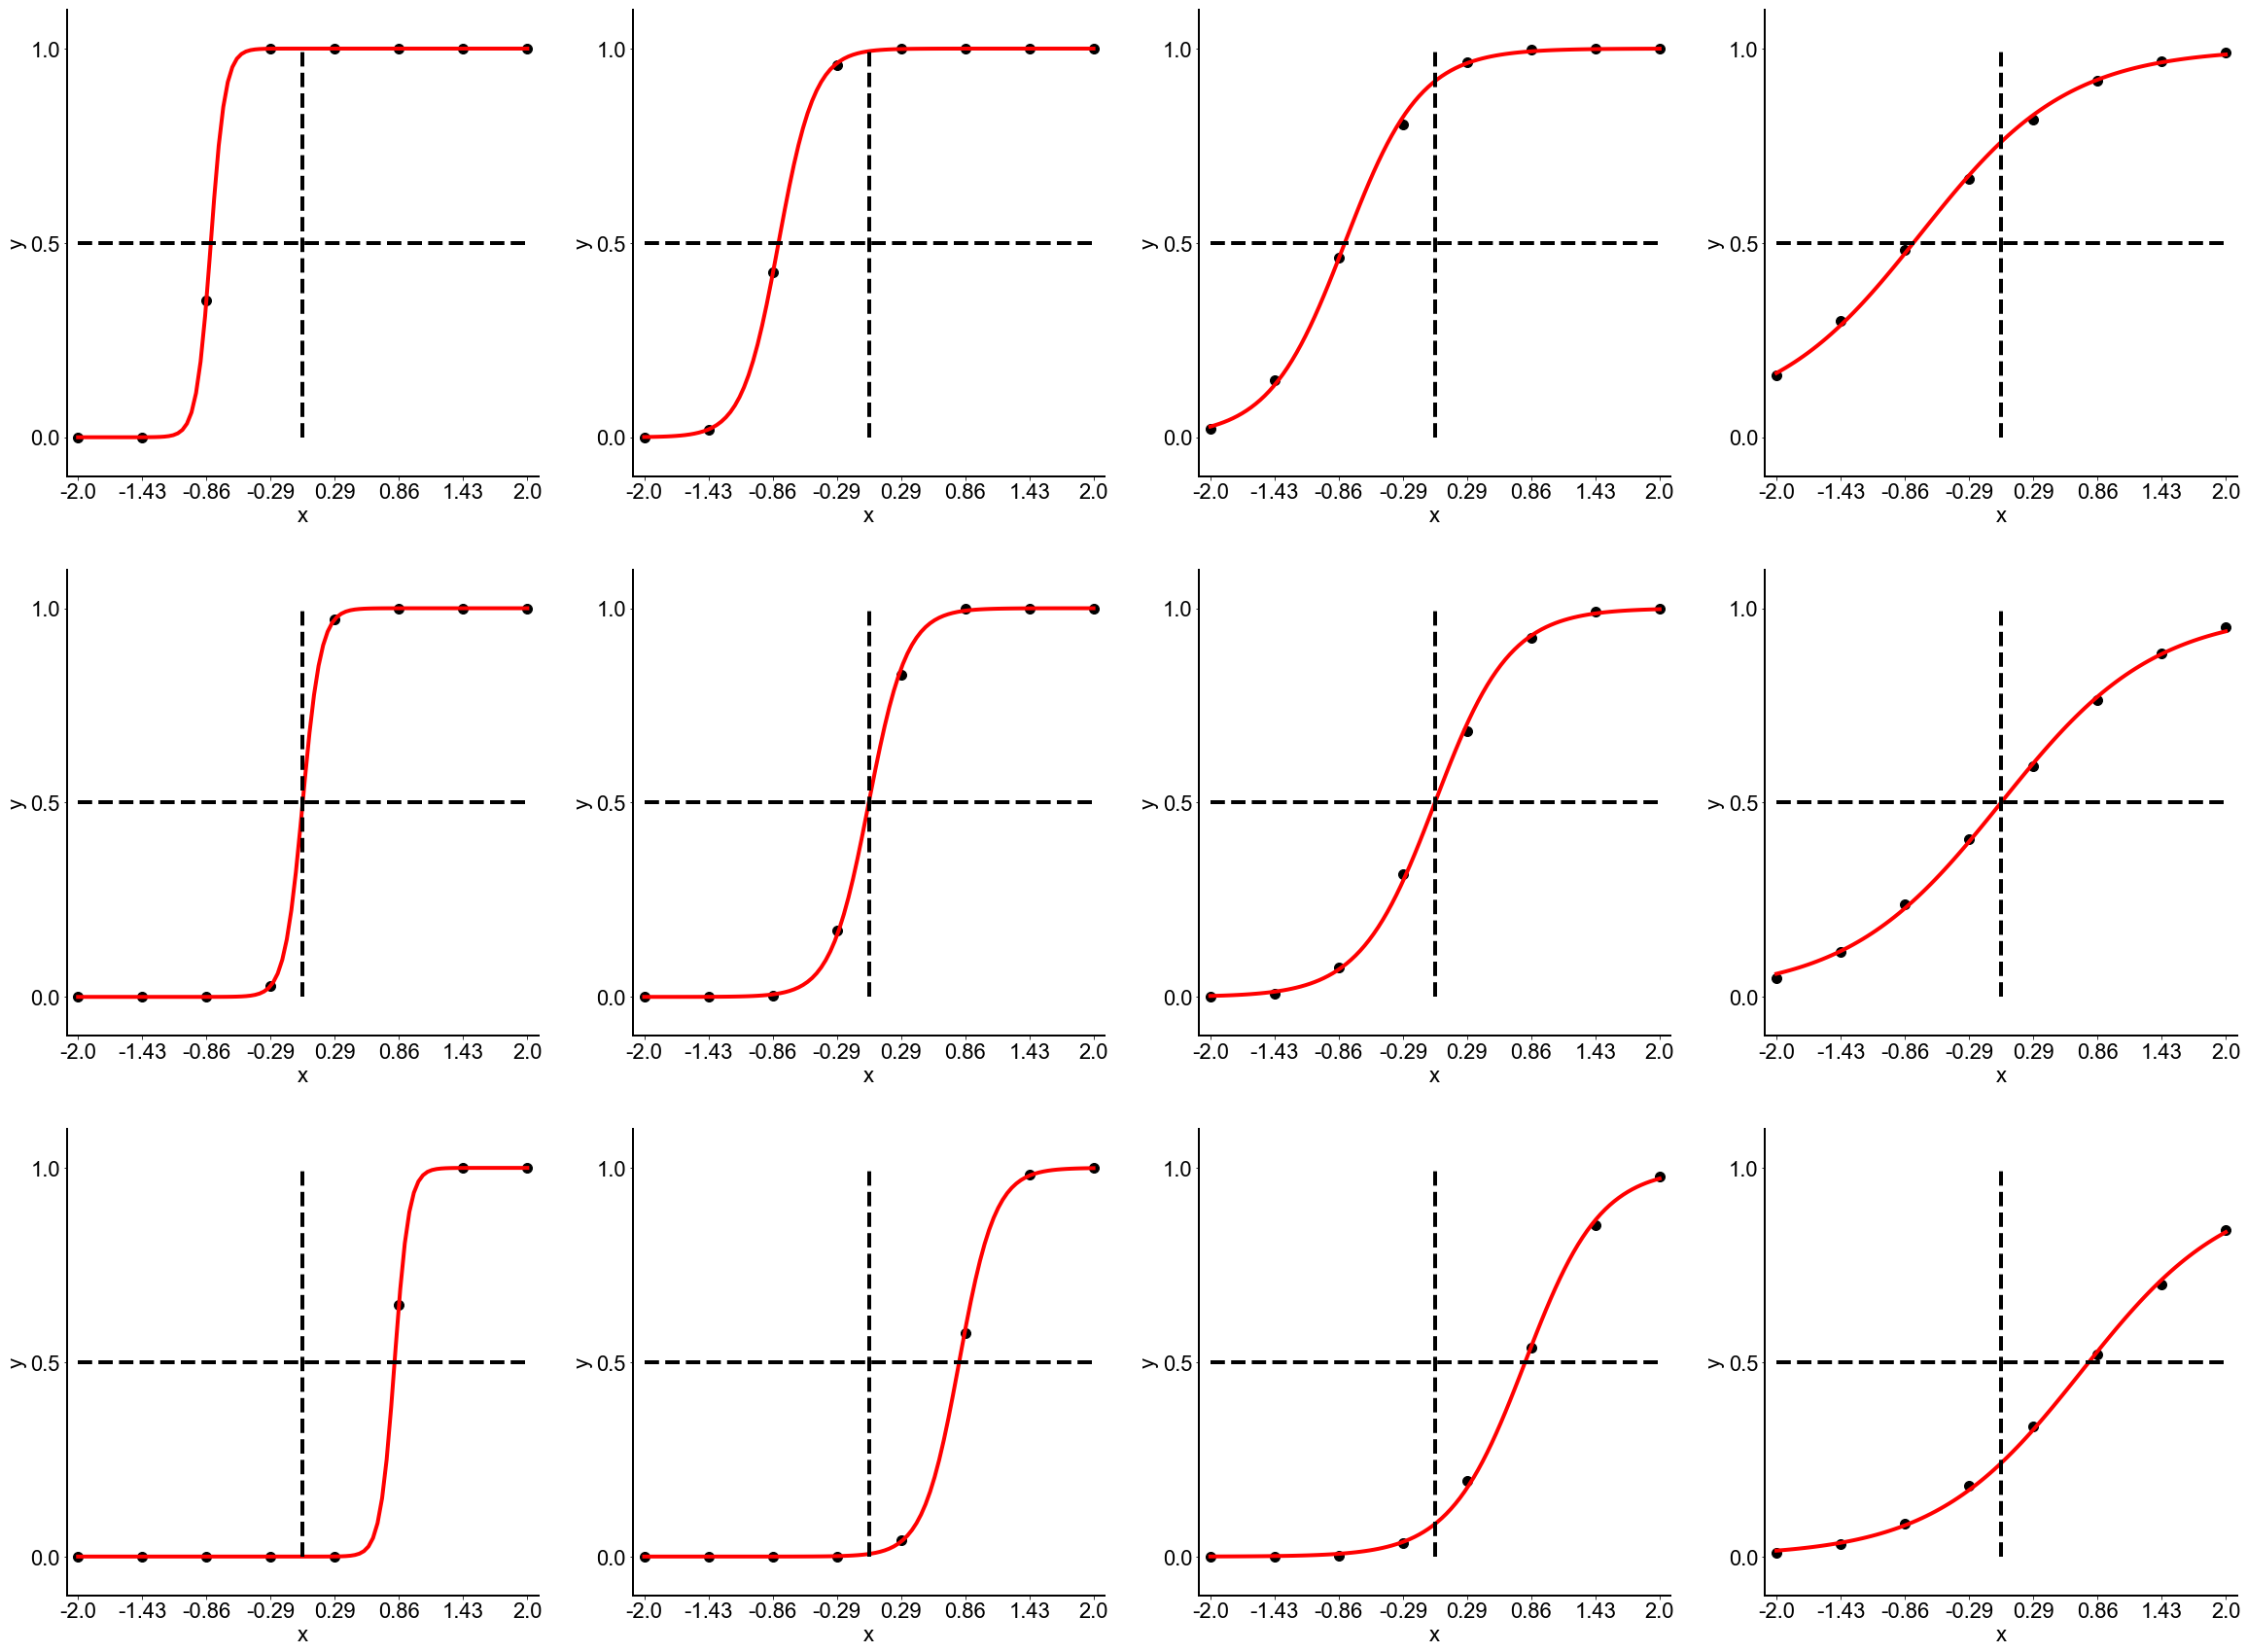

In [8]:

fig, ax = plt.subplots(response.shape[2],response.shape[1], figsize=(response.shape[1]*10, response.shape[2]*10))
ax = np.ravel(ax)

i=0
for t,thr in enumerate(crit):
    for v,sgm in enumerate(var):
    
        M = logistic_model((x,response[:,v,t],N))
        M.logistic_fit()
        ax[i].plot(x,response[:,v,t],'o', markersize=10, color = 'k')
        ax[i].plot(M.pred[0,:],M.pred[1,:], '-',linewidth = lw, color = 'r')
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            label.set_fontname(axisFont['fontname'])
            label.set_fontsize(axisFont['size'])
        ax[i].plot([np.min(x), np.max(x)],[0.5,0.5],'k--',linewidth = lw)
        ax[i].plot([0, 0],[0,1],'k--',linewidth = lw)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_linewidth(axisWidth)
        ax[i].spines['bottom'].set_linewidth(axisWidth)
        ax[i].xaxis.set_ticks_position('bottom')
        ax[i].yaxis.set_ticks_position('left')
        ax[i].set_xlabel('x', **axisFont)
        ax[i].set_ylabel('y', **axisFont)
        ax[i].set_xlim([-2.1,2.1])
        ax[i].set_ylim([-0.1,1.1])
        ax[i].xaxis.set_ticks(x)
        ax[i].yaxis.set_ticks([0,0.5,1])
        ax[i].xaxis.set_ticklabels(np.round(x,2))
        i=i+1
    #plt.savefig('logistic_fit.pdf')
plt.show()

# Fitting the Cummulative Gaussian model (the true underlying model)

In [9]:
class CDF_gauss_model:
    
    """ Fitting a logistic model """
    
    def __init__(self, fit_data):
        
        self.eps = 2.2204e-16
        self.x = fit_data[0]
        self.y = fit_data[1]
        self.n = fit_data[2]

        
    def CDF_gauss_fit(self):
    #[bhat, logl,xi,yi]=weibull_fit(x,y)
    #Fits the weibull model to (x,y) data set and returns the estimates bhat
    #and the log-likeliihood (logl) and interpolated xi and yi from fit
    #
    #The weibull function is P(correct)=1-0.5 exp[-(x/alpha)^beta]
    #here bhat(1)=alpha amd bhat(2)=beta
        bnds = ((np.min(self.x), np.max(self.x)), (0+self.eps, None), (0, 0.5), (0.5, 1))
        self.CDF_gauss_jac()
        res = minimize(self.CDF_gauss_dist,(0,  1,  0.1,  0.9), args = (self.x, self.y, self.n), bounds = bnds)

        self.opt_param = res.x
        self.nlogl = res.fun

        xi=np.linspace(min(self.x),max(self.x),100)
        yi=self.CDF_gauss_pred(xi, self.opt_param)      
        self.pred = np.vstack((xi,yi))


    def CDF_gauss_dist(self,b,x,y,n):
    #returns the log likelihood

    #this is the weibull function that we are fitting
    #goes between p =0.5 and p=1.0
    #paramerized with squares to ensure that the params are positive

        p = self.CDF_gauss_pred(x,b)                     
        p=np.clip(p,self.eps,1-self.eps)
        return -n*np.sum(y * np.log(p) + (1-y) * np.log(1-p))
    
    
    def CDF_gauss_jac(self):
        
        b0,b1,b2,b3,x,y = sp.symbols(('b0','b1','b2','b3','x','y'),real=True)

        p = b2 + (1-b2-(1-b3)) * (0.5*(1+sp.erf(b1*(x-b0))))
        f = -(y * sp.log(p) + (1-y) * sp.log(1-p))
        f = sp.simplify(f)
        vars = (b0,b1,b2,b3)
        J = sp.zeros(1,len(vars))
        for j, s in enumerate(vars):
            J[j] = sp.simplify(sp.diff(f, s))
        
        global J0,J1,J2,J3

        def scipyerf(x):
            return erf(x)
        def npexp(x):
            return np.exp(x)
        def npsqrt(x):
            return np.sqrt(x)
        def nppi(x):
            return np.pi(x)
        
        J0 = sp.lambdify((b0,b1,b2,b3,x,y), J[0], [{'erf': scipyerf}, 'scipy',{'exp': npexp}, 'numpy',{'sqrt': npsqrt}, 'numpy',{'pi': nppi}, 'numpy'])
        J1 = sp.lambdify((b0,b1,b2,b3,x,y), J[1], [{'erf': scipyerf}, 'scipy',{'exp': npexp}, 'numpy',{'sqrt': npsqrt}, 'numpy',{'pi': nppi}, 'numpy'])
        J2 = sp.lambdify((b0,b1,b2,b3,x,y), J[2], [{'erf': scipyerf}, 'scipy',{'exp': npexp}, 'numpy',{'sqrt': npsqrt}, 'numpy',{'pi': nppi}, 'numpy'])
        J3 = sp.lambdify((b0,b1,b2,b3,x,y), J[3], [{'erf': scipyerf}, 'scipy',{'exp': npexp}, 'numpy',{'sqrt': npsqrt}, 'numpy',{'pi': nppi}, 'numpy'])
        
        
    def CDF_gauss_jac_calc(self,b,x,y,n):

        jac0 = np.nansum(n*J0(b[0],b[1],b[2],b[3],x,y))
        jac1 = np.nansum(n*J1(b[0],b[1],b[2],b[3],x,y))
        jac2 = np.nansum(n*J2(b[0],b[1],b[2],b[3],x,y))
        jac3 = np.nansum(n*J3(b[0],b[1],b[2],b[3],x,y))

        return np.array([jac0,jac1,jac2,jac3])
    

    def CDF_gauss_pred(self, x ,b):

        return b[2] + (1-b[2]-(1-b[3])) * (st.norm.cdf(x, loc=b[0], scale=1/b[1]))

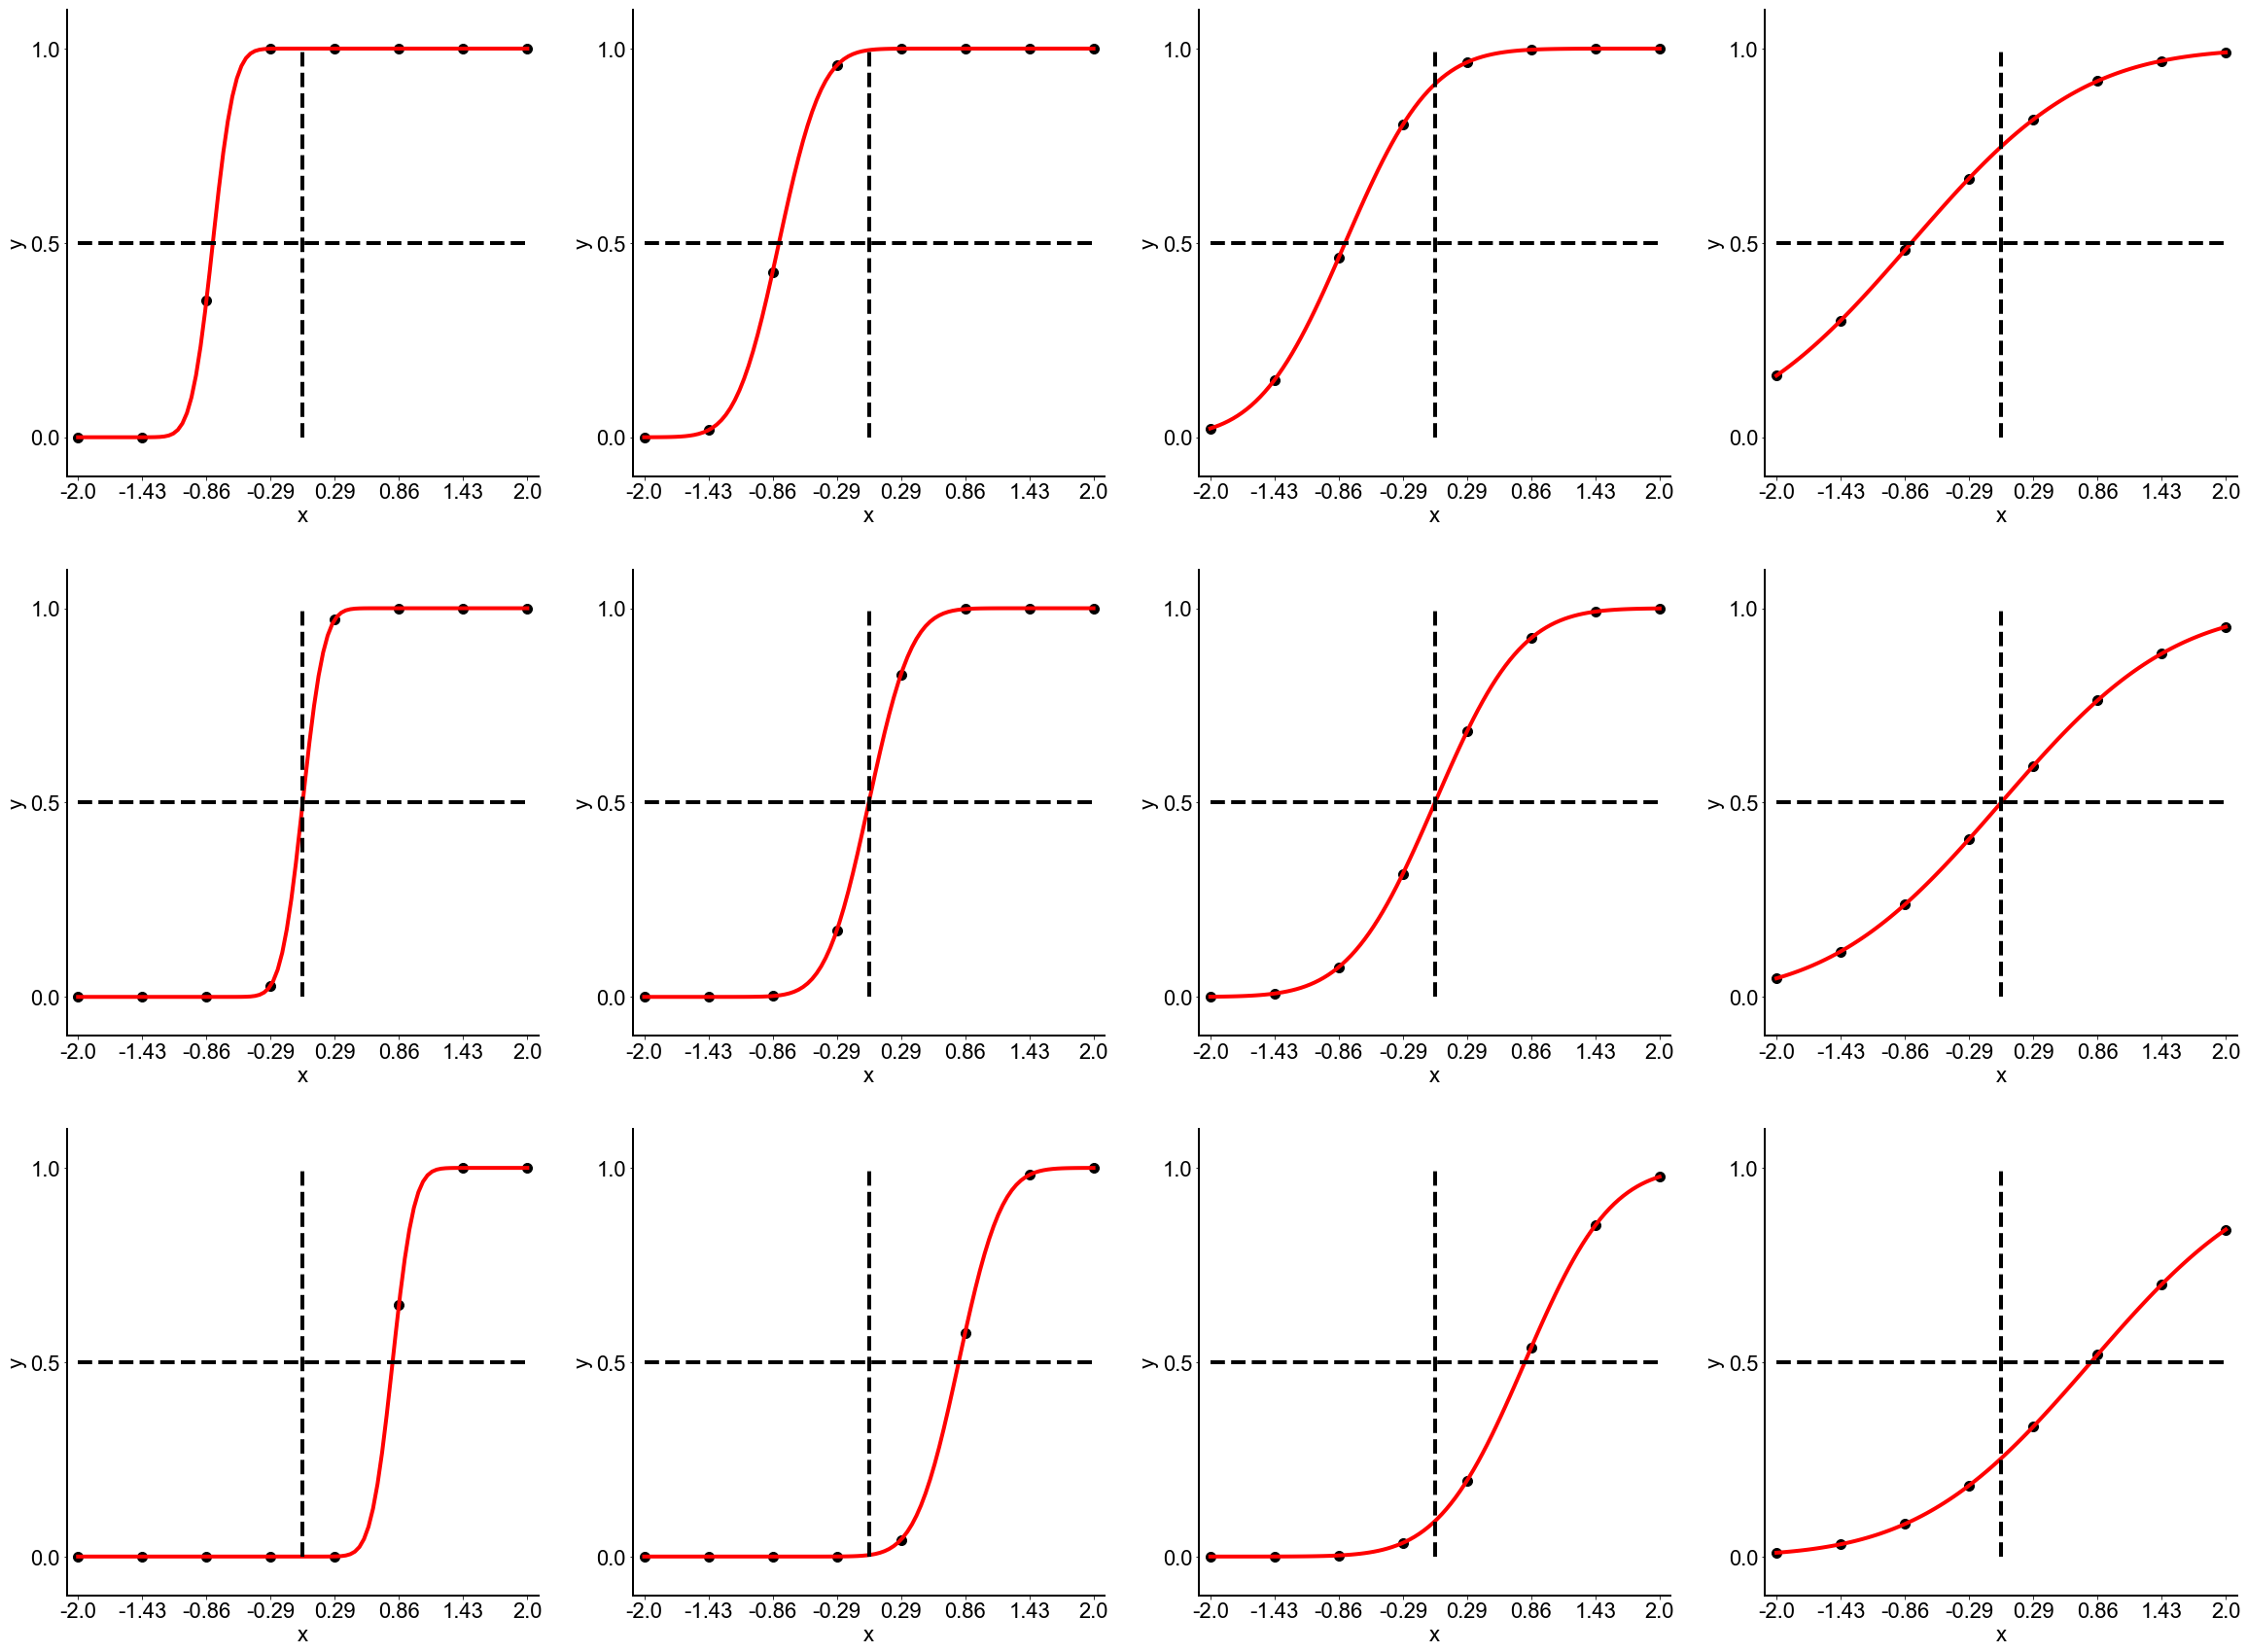

In [10]:

fig, ax = plt.subplots(response.shape[2],response.shape[1], figsize=(response.shape[1]*10, response.shape[2]*10))
ax = np.ravel(ax)

i=0
for t,thr in enumerate(crit):
    for v,sgm in enumerate(var):

        M = CDF_gauss_model((x,response[:,v,t],N))
        M.CDF_gauss_fit()
        ax[i].plot(x,response[:,v,t],'o', markersize=10, color = 'k')
        ax[i].plot(M.pred[0,:],M.pred[1,:], '-',linewidth = lw, color = 'r')
        for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            label.set_fontname(axisFont['fontname'])
            label.set_fontsize(axisFont['size'])
        ax[i].plot([np.min(x), np.max(x)],[0.5,0.5],'k--',linewidth = lw)
        ax[i].plot([0, 0],[0,1],'k--',linewidth = lw)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['left'].set_linewidth(axisWidth)
        ax[i].spines['bottom'].set_linewidth(axisWidth)
        ax[i].xaxis.set_ticks_position('bottom')
        ax[i].yaxis.set_ticks_position('left')
        ax[i].set_xlabel('x', **axisFont)
        ax[i].set_ylabel('y', **axisFont)
        ax[i].set_xlim([-2.1,2.1])
        ax[i].set_ylim([-0.1,1.1])
        ax[i].xaxis.set_ticks(x)
        ax[i].yaxis.set_ticks([0,0.5,1])
        ax[i].xaxis.set_ticklabels(np.round(x,2))
        i=i+1
    #plt.savefig('cummulative_normal_fit.pdf')
plt.show()